# Gradient Boosting

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

In [4]:
df_new = pd.read_csv("data_set.csv")
duplicates = df_new.duplicated().any()

pd.set_option('display.max_rows', 50)
df_new

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


# Gradient Boosting Up-sampling

Data shape: (9630, 11)
Best hyperparameters: {'learning_rate': 0.05, 'n_estimators': 150}
Accuracy metric: 0.832
Precision metric: 0.791
Recall metric: 0.9
F1 metric: 0.831


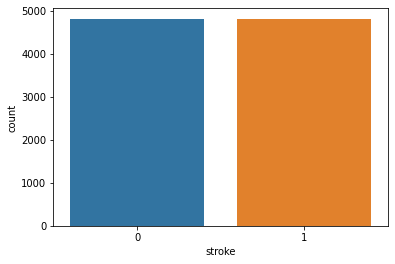

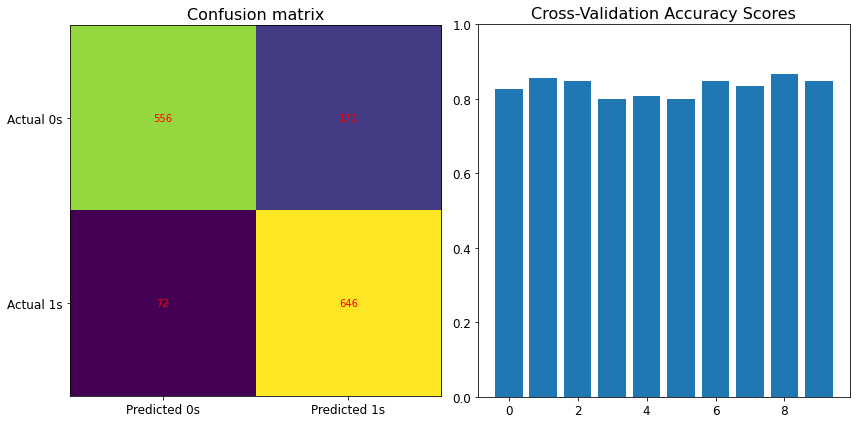


Classification report: 
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       727
           1       0.79      0.90      0.84       718

    accuracy                           0.83      1445
   macro avg       0.84      0.83      0.83      1445
weighted avg       0.84      0.83      0.83      1445


Score: 
0.832 



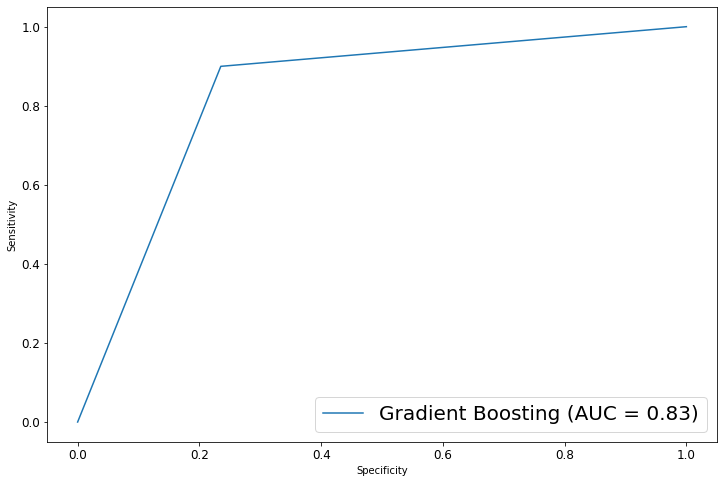

Area under ROC curve: 0.832


In [9]:
df = df_new.copy()
df = df.drop('id', axis=1)
mean_bmi = round(df['bmi'].mean(), 1)
df_new['bmi'].fillna(mean_bmi, inplace=True)

df = df[(df['bmi'] >= 15) & (df['bmi'] <= 70)]

label_encoder = LabelEncoder()
df['gender'] = label_encoder.fit_transform(df['gender'])
df['ever_married'] = label_encoder.fit_transform(df['ever_married'])
df['work_type'] = label_encoder.fit_transform(df['work_type'])
df['Residence_type'] = label_encoder.fit_transform(df['Residence_type'])
df['smoking_status'] = label_encoder.fit_transform(df['smoking_status'])

scaler = MinMaxScaler()
df['age'] = scaler.fit_transform(df[['age']])
df['avg_glucose_level'] = scaler.fit_transform(df[['avg_glucose_level']])
df['bmi'] = scaler.fit_transform(df[['bmi']])

class_0 = df[df['stroke'] == 0]
class_1 = df[df['stroke'] == 1]

class_1_oversampled = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)
oversampled_data = pd.concat([class_0, class_1_oversampled])
df = oversampled_data

X = df.drop(['stroke', 'gender', 'hypertension', 'Residence_type', 'smoking_status'], axis=1)
target = df['stroke']

sns.countplot(x='stroke', data=df)
value_counts = df['stroke'].value_counts()

print("Data shape:", df.shape)

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.15, random_state=42)

param_grid = {
    "learning_rate": [0.01, 0.05],
    "n_estimators": [50, 100, 150]
}

clf = GradientBoostingClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

clf_best = GradientBoostingClassifier(**best_params)
clf_best.fit(X_train, y_train)
y_pred = clf_best.predict(X_test)

print("Accuracy metric:", round(metrics.accuracy_score(y_test, y_pred), 3))
print("Precision metric:", round(metrics.precision_score(y_test, y_pred), 3))
print("Recall metric:", round(metrics.recall_score(y_test, y_pred), 3))
print("F1 metric:", round(f1_score(y_test, y_pred, average='macro'), 3))

score = clf_best.score(X_test, y_test)
cm = metrics.confusion_matrix(y_test, clf_best.predict(X_test))
cross_val_scores = cross_val_score(clf_best, X_test, y_test, cv=10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(cm)
ax1.grid(False)
ax1.set_title('Confusion matrix', fontsize=16)
ax1.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax1.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax1.set_ylim(1.5, -0.5)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
for i in range(2):
    for j in range(2):
        ax1.text(j, i, cm[i, j], ha='center', va='center', color='red')

ax2.bar(range(len(cross_val_scores)), cross_val_scores)
ax2.xaxis.set(label='Cross validation batch')
ax2.yaxis.set(label='Score')
ax2.set_title('Cross-Validation Accuracy Scores', fontsize=16)
ax2.set_ylim(0.0, 1.0)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

print("\nClassification report: ")
print(metrics.classification_report(y_test, y_pred))
print("\nScore: ")
print(round(score, 3), '\n')

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 8))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Gradient Boosting')
display.plot(ax=ax)
ax.legend(fontsize=20)
plt.xlabel("Specificity")
plt.ylabel("Sensitivity")
plt.show()

area_under_curve = roc_auc_score(y_test, y_pred)
print('Area under ROC curve:', round(area_under_curve, 3))

# Gradient Boosting Down-sampling

Data shape: (498, 11)
Best hyperparameters: {'learning_rate': 0.01, 'n_estimators': 50}
Accuracy metric: 0.813
Precision metric: 0.769
Recall metric: 0.857
F1 metric: 0.813


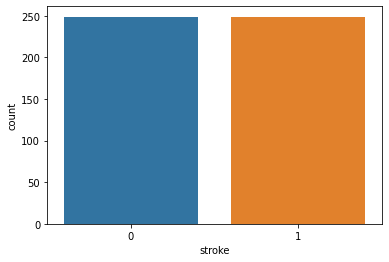

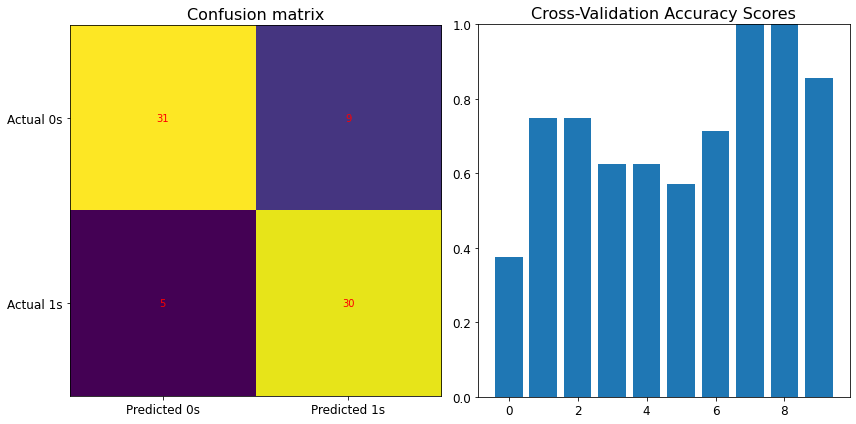


Classification report: 
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        40
           1       0.77      0.86      0.81        35

    accuracy                           0.81        75
   macro avg       0.82      0.82      0.81        75
weighted avg       0.82      0.81      0.81        75


Score: 
0.813 



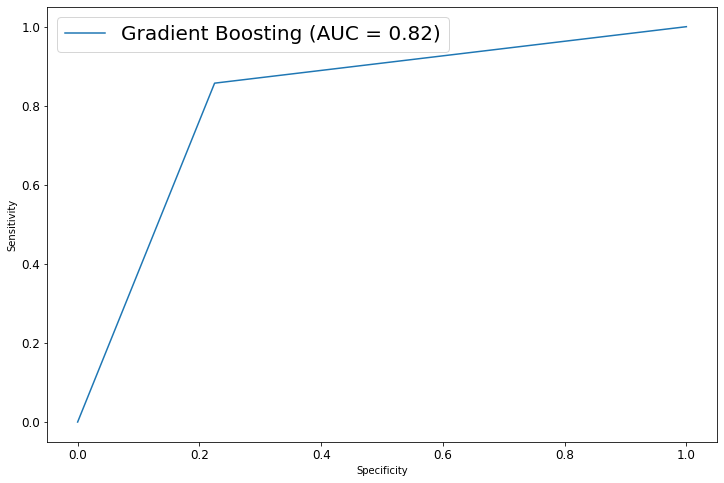

Area under ROC curve: 0.816


In [10]:
df = df_new.copy()
df = df.drop('id', axis=1)
mean_bmi = round(df['bmi'].mean(), 1)
df_new['bmi'].fillna(mean_bmi, inplace=True)

df = df[(df['bmi'] >= 15) & (df['bmi'] <= 70)]

label_encoder = LabelEncoder()
df['gender'] = label_encoder.fit_transform(df['gender'])
df['ever_married'] = label_encoder.fit_transform(df['ever_married'])
df['work_type'] = label_encoder.fit_transform(df['work_type'])
df['Residence_type'] = label_encoder.fit_transform(df['Residence_type'])
df['smoking_status'] = label_encoder.fit_transform(df['smoking_status'])

scaler = MinMaxScaler()
df['age'] = scaler.fit_transform(df[['age']])
df['avg_glucose_level'] = scaler.fit_transform(df[['avg_glucose_level']])
df['bmi'] = scaler.fit_transform(df[['bmi']])

class_0 = df[df['stroke'] == 0]
class_1 = df[df['stroke'] == 1]

class_0_undersampled = resample(class_0, replace=False, n_samples=len(class_1), random_state=42)
undersampled_data = pd.concat([class_0_undersampled, class_1])
df = undersampled_data

X = df.drop(['stroke', 'gender', 'hypertension', 'Residence_type', 'smoking_status'], axis=1)
target = df['stroke']

sns.countplot(x='stroke', data=df)
value_counts = df['stroke'].value_counts()

print("Data shape:", df.shape)

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.15, random_state=42)

param_grid = {
    "learning_rate": [0.01, 0.05],
    "n_estimators": [50, 100, 150]
}

clf = GradientBoostingClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

clf_best = GradientBoostingClassifier(**best_params)
clf_best.fit(X_train, y_train)
y_pred = clf_best.predict(X_test)

print("Accuracy metric:", round(metrics.accuracy_score(y_test, y_pred), 3))
print("Precision metric:", round(metrics.precision_score(y_test, y_pred), 3))
print("Recall metric:", round(metrics.recall_score(y_test, y_pred), 3))
print("F1 metric:", round(f1_score(y_test, y_pred, average='macro'), 3))

score = clf_best.score(X_test, y_test)
cm = metrics.confusion_matrix(y_test, clf_best.predict(X_test))
cross_val_scores = cross_val_score(clf_best, X_test, y_test, cv=10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(cm)
ax1.grid(False)
ax1.set_title('Confusion matrix', fontsize=16)
ax1.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax1.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax1.set_ylim(1.5, -0.5)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
for i in range(2):
    for j in range(2):
        ax1.text(j, i, cm[i, j], ha='center', va='center', color='red')

ax2.bar(range(len(cross_val_scores)), cross_val_scores)
ax2.xaxis.set(label='Cross validation batch')
ax2.yaxis.set(label='Score')
ax2.set_title('Cross-Validation Accuracy Scores', fontsize=16)
ax2.set_ylim(0.0, 1.0)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

print("\nClassification report: ")
print(metrics.classification_report(y_test, y_pred))
print("\nScore: ")
print(round(score, 3), '\n')

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 8))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Gradient Boosting')
display.plot(ax=ax)
ax.legend(fontsize=20)
plt.xlabel("Specificity")
plt.ylabel("Sensitivity")
plt.show()

area_under_curve = roc_auc_score(y_test, y_pred)
print('Area under ROC curve:', round(area_under_curve, 3))